# Portfolio Optimization

## import required libraries

In [32]:
import yfinance as yf
import pandas as pd
from datetime import datetime,timedelta
import numpy as np
from scipy.optimize import minimize

## Define the list of tickers

In [33]:
tickers=['SPY','BND','GLD','QQQ','VTI']

## Set the end date to today

In [34]:
end_date=datetime.today()

## Set the start date to 10 years ago

In [35]:
start_date=end_date-timedelta(days=10*365)

## Create an empty dataframe to store the adjusted close prices

In [36]:
adj_close_df=pd.DataFrame()

## Download the closed prices for each ticker

In [37]:
for ticker in tickers:
    data=yf.download(ticker,start=start_date,end=end_date,auto_adjust=True)
    adj_close_df[ticker]=data['Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


## Display the dataframe

In [38]:
print(adj_close_df)

                   SPY        BND         GLD         QQQ         VTI
Date                                                                 
2015-06-24  177.446060  61.310024  112.589996  102.319511   92.609131
2015-06-25  176.906525  61.226963  112.440002  102.115288   92.322586
2015-06-26  176.872787  61.113693  112.559998  101.437622   92.270073
2015-06-29  173.163712  61.423332  113.070000   99.042564   90.340225
2015-06-30  173.526230  61.362923  112.370003   99.395302   90.585686
...                ...        ...         ...         ...         ...
2025-06-13  595.240295  72.699997  316.290009  526.960022  293.570007
2025-06-16  600.903564  72.559998  311.779999  534.289978  296.470001
2025-06-17  595.768799  72.790001  311.940002  529.080017  294.000000
2025-06-18  595.679016  72.830002  310.260010  528.989990  294.109985
2025-06-20  594.280029  72.879997  310.130005  526.830017  293.429993

[2513 rows x 5 columns]


## Calculate the lognormal returns for each ticker

In [39]:
log_returns=np.log(adj_close_df/adj_close_df.shift(1))

## Drop any missing values

In [40]:
log_returns=log_returns.dropna()

## Calculate the covariance matrix of the tickers using annualized log returns

In [41]:
cov_matrix=log_returns.cov()*252 #252 is multiplied to annualize the logreturns

In [42]:
print(cov_matrix)

          SPY       BND       GLD       QQQ       VTI
SPY  0.033703  0.001155  0.001217  0.038834  0.034212
BND  0.001155  0.003040  0.002744  0.001436  0.001245
GLD  0.001217  0.002744  0.020835  0.001803  0.001326
QQQ  0.038834  0.001436  0.001803  0.051298  0.039360
VTI  0.034212  0.001245  0.001326  0.039360  0.034998


## Calculate the portfolio standard deviation

In [43]:
def standard_deviation(weights,cov_matrix):
    variance=weights.T@cov_matrix@weights
    return np.sqrt(variance)

## Calculate the expected returns

In [44]:
def expected_returns(weights,log_returns):
    return np.sum(log_returns.mean()*weights)*252

## Calculate the Sharpe ratio

In [45]:
def sharpe_ratio(weights,log_returns,cov_matrix,risk_free_rate):
    return (expected_returns(weights,log_returns)-risk_free_rate)/standard_deviation(weights,cov_matrix)

## Set the risk_free_rate

In [46]:
risk_free_rate=0.02 # 2%

## Define the function to minimize(-ve Sharpe ratio)

In [47]:
def neg_sharpe_ratio(weights,log_returns,cov_matrix,risk_free_rate):
    return -sharpe_ratio(weights,log_returns,cov_matrix,risk_free_rate)

## Set the constraints and the bounds

In [48]:
constraints={'type' : 'eq' , 'fun' : lambda weights: np.sum(weights)-1} # sum of the weights=1
bounds=[(0,0.45) for _ in range(len(tickers))] # lower bound is 0 which implies that we cant short it and the upper bound is 0.5 which means that the maximum weight we can assign to a ticker is 0.5(50%)

## Set the initial weights

In [49]:
initial_weights=np.array([1/len(tickers)]*len(tickers))

In [50]:
print(initial_weights)

[0.2 0.2 0.2 0.2 0.2]


## Optimize the weights to maximize the sharpe ratio

In [51]:
optimized_results=minimize(neg_sharpe_ratio,x0=initial_weights,args=(log_returns,cov_matrix,risk_free_rate),method='SLSQP',constraints=constraints,bounds=bounds)#Sequential Least Squares Quadratic Programming used for optimizing the weights 

## Get the optimal weights

In [52]:
optimal_weights=optimized_results.x

## Display the analytics of the optimal portfolio

In [53]:
print("Optimal Weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

optimal_portfolio_return = expected_returns(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected Annual Returns: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Optimal Weights:
SPY: 0.0097
BND: 0.0903
GLD: 0.4500
QQQ: 0.4500
VTI: 0.0000
Expected Annual Returns: 0.1225
Expected Volatility: 0.1267
Sharpe Ratio: 0.8086


## Display the final portfolio in a plot

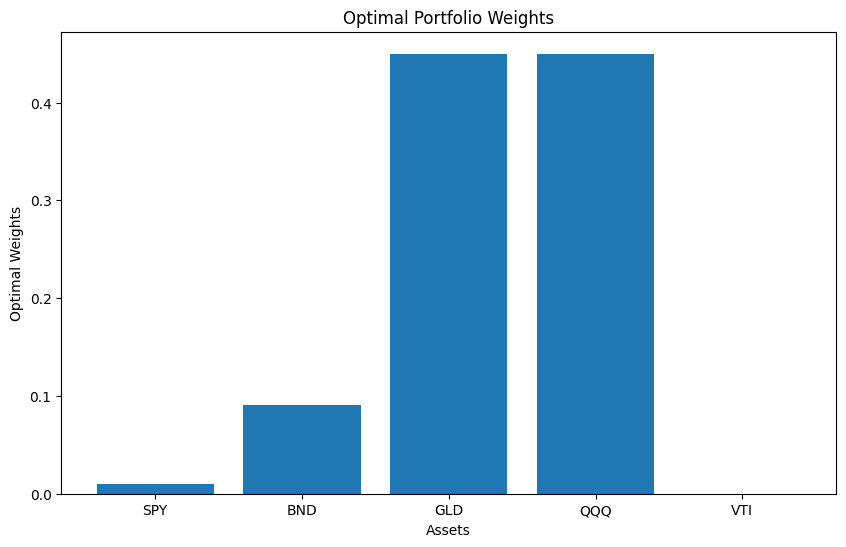

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(tickers, optimal_weights)

plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')

plt.show()